# Active Session 1: Introduction to CNN

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cihan-ates/data-driven-engineering/blob/master/DDE_II_Advanced_Topics/Lecture%202/Lecture_2.ipynb)


#Important Note

Lecture notes and notebooks must not be copied and/or distributed without the express permission of ITS.





#1. Problem Definition: Probing into the Data

In this dataset, we will explore a medical case study: (malignant) melanoma, which is a type of skin cancer that develops from the pigment-producing cells known as melanocytes. 

Identifying melanoma at an early stage is very crucial; as  the early detection can vastly increase your chances for cure up to 99%. The survival rate drops from to 66% if the disease reaches the lymph nodes and
27% if it spreads to distant organs [[1]](https://www.skincancer.org/skin-cancer-information/melanoma/melanoma-warning-signs-and-images/). 

The problem has serious consequences hence has been addressed by the community in different ways, mainly revolving around alternative CNN architectures and pre-trained and/or attention based models. We will use a relatively smaller database as an exercise to explore the CNN implementation in TF and how to call pre-trained models for the task later on. 




# 2. Preparing the enviroment

Import the Python libraries that we will need to (i) load the data, (ii) analyze it, (iii) create our model, (iv) process the results.

In [ ]:
!pip install ipython-autotime
%load_ext autotime

time: 1.78 ms (started: 2021-05-05 17:23:33 +00:00)


In [ ]:
#Importing the necessary libraries
import math
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from glob import glob
from PIL import Image
import cv2

time: 847 ms (started: 2021-05-05 17:23:33 +00:00)


In [ ]:
# Data Preparation and Scoring
from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from matplotlib.colors import LogNorm
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools
from tqdm import tqdm
from tensorflow.keras.utils import plot_model
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score,plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, cohen_kappa_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from keras.preprocessing.image import ImageDataGenerator


time: 3.49 s (started: 2021-05-05 17:23:34 +00:00)


In [ ]:
# ML Algorithms to be used
import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, Input, Lambda, Flatten

from keras.utils.np_utils import to_categorical

tf.__version__


'2.4.1'

time: 13.5 ms (started: 2021-05-05 17:23:38 +00:00)


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0
time: 569 ms (started: 2021-05-05 17:23:38 +00:00)


# 3. Pre-processing


## Loading the Data

We need to upload the dataset to Colab enviroment. The original  dataset is coming from the ISIC (International Skin Image Collaboration) Archive. It includes 1800 pictures of benign moles and 1497 pictures of malignant classified moles. The database have all been resized to low resolution (224x224x3) RGB. 

The data can be either loaded manually or can be read from google drive. We will follow the second route.

In [ ]:
# Loading the data

#Local drive:
#from google.colab import files
#uploaded = files.upload()


time: 1.58 ms (started: 2021-05-05 17:23:38 +00:00)


In [ ]:
# Loading the data
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

time: 3.28 s (started: 2021-05-05 17:23:38 +00:00)


In [ ]:
# Note that you need to insert your own id for your file in the cloud.
CNN_data = drive.CreateFile({'id':'1fzaWN9j6FGIvkdaj6qJIKHZJRS9gP-ty'}) 
CNN_data.GetContentFile('CNN.zip')


time: 6.95 s (started: 2021-05-05 17:23:42 +00:00)


In [ ]:
# The file is downloaded on the cloud workspace:
!ls

adc.json  data		      my_best_model_3.h5  sample_data  train
CNN.zip   my_best_model_2.h5  my_best_model.h5	  test
time: 167 ms (started: 2021-05-05 17:23:48 +00:00)


In [ ]:
#Unzipping the flie:
!unzip -qq CNN.zip
!ls

replace data/test/benign/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
adc.json  data		      my_best_model_3.h5  sample_data  train
CNN.zip   my_best_model_2.h5  my_best_model.h5	  test
time: 4.44 s (started: 2021-05-05 17:23:49 +00:00)


## Train-Test Split

OUr task is binary classification, which is supervised learning. Therefore, we need to create a train/test split. In the original dataset, this was already done to present the same split to those who would dive into the challange -- just be fair. So our task here is to take these folders, create objects and assign labels based on the folder they belong to. 

Note that we do not have any other features. A more recent, higher resolution database also provides additional information on the samples. You can eplore the newer challange from here:

https://www.kaggle.com/c/siim-isic-melanoma-classification

We will look into a bit older but smaller dataset, particularly to discuss the role of transfer learning in the following lecture. 

Now returning back to our problem, lets create our training-test data:

In [ ]:
# Creating a function to read the images from the files:
def image_reader(directory,size=224):
    images = []
    # We are going to use Python Imaging Library for image management.
    #for more, you can check:
    #https://pillow.readthedocs.io/en/stable/reference/Image.html#
    #https://pillow.readthedocs.io/en/stable/reference/Image.html?highlight=convert#PIL.Image.Image.convert
    readed = lambda image_name: np.asarray(Image.open(image_name).convert("RGB"))
    # We will create a loop for reading images in a given directory and resize it if needed.
    #---------------------------------------------------------------------------
    # Just to have a cool window in the progress, we will use tqdm.
    # "tqdm derives from the Arabic word taqaddum (تقدّم) which can mean “progress,” 
    # and is an abbreviation for “I love you so much” in Spanish (te quiero demasiado). 
    # Instantly make your loops show a smart progress meter - just wrap any iterable with 
    # tqdm(iterable), and you're done!".
    #---------------------------------------------------------------------------
    for i_image in tqdm(os.listdir(directory)):
        PATH = os.path.join(directory,i_image)
        img_loop = readed(PATH)
        # Resizing image if needed:
        img_loop = cv2.resize(img_loop, (size,size))
        # Normalizing the colors
        #-----------------------------------------------------------------------
        # RGB (Red, Green, Blue) are 8 bit each and the range for each individual 
        # colour is 0-255 (2^8 = 256). By dividing by 255, the 0-255 range is converted to
        # a range between 0.0-1.0.
        #-----------------------------------------------------------------------
        images.append(np.array(img_loop)/255.)
    return images

time: 17 ms (started: 2021-05-05 17:23:53 +00:00)


In [ ]:
#lets remember the files:
!ls

adc.json  data		      my_best_model_3.h5  sample_data  train
CNN.zip   my_best_model_2.h5  my_best_model.h5	  test
time: 162 ms (started: 2021-05-05 17:23:53 +00:00)


In [ ]:
# Reading the images
#train data:
benign_train = np.array(image_reader('./data/train/benign'))
malignant_train = np.array(image_reader('./data/train/malignant'))
#test data:
benign_test = np.array(image_reader('./data/test/benign'))
malignant_test = np.array(image_reader('./data/test/malignant'))

100%|██████████| 300/300 [00:00<00:00, 319.13it/s]


time: 17.6 s (started: 2021-05-05 17:23:53 +00:00)


Note that the ratio of benign/malignant is relatively balanced. This is an important information as it affects our evaluation matrices (you may check the classification lecture of DDE1 for further information). 

Now we have read the images and converted them into numpy arrays. The next step is to create labels. This could have been done with the `image_reader` as well. 

In [ ]:
print(np.shape(benign_train), np.shape(benign_test))
print(np.shape(malignant_train), np.shape(malignant_test))

(1440, 224, 224, 3) (360, 224, 224, 3)
(1197, 224, 224, 3) (300, 224, 224, 3)
time: 3.03 ms (started: 2021-05-05 17:24:11 +00:00)


In [ ]:
# Creating individual labels:
#----------------------------
y_benign_train = np.zeros(benign_train.shape[0])
y_malignant_train = np.ones(malignant_train.shape[0])
y_benign_test = np.zeros(benign_test.shape[0])
y_malignant_test = np.ones(malignant_test.shape[0])
#
# Merging the arrays: 
#----------------------------
#images:
X_train = np.concatenate((benign_train, malignant_train), axis = 0)
#labels:
y_train = np.concatenate((y_benign_train, y_malignant_train), axis = 0)
#images:
X_test = np.concatenate((benign_test, malignant_test), axis = 0)
#labels:
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

time: 1.98 s (started: 2021-05-05 17:24:11 +00:00)


In [ ]:
del benign_train, malignant_train, benign_test, malignant_test
del y_benign_train, y_malignant_train, y_benign_test, y_malignant_test

time: 11.8 ms (started: 2021-05-05 17:24:13 +00:00)


In [ ]:
# Since the data is perfectly ordered in label, we need to suffle it:
#
# first we will create a list of random numbers with the same size of our arrays.
# then reorder them accordingly.
s = np.arange(X_train.shape[0])
np.random.shuffle(s) 
X_train = X_train[s]
y_train = y_train[s]
# The same is done for the test data:
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

time: 3.8 s (started: 2021-05-05 17:24:13 +00:00)


## Visualization of the samples
We do not have many options for EDA. Lets see how the image samples look like. 

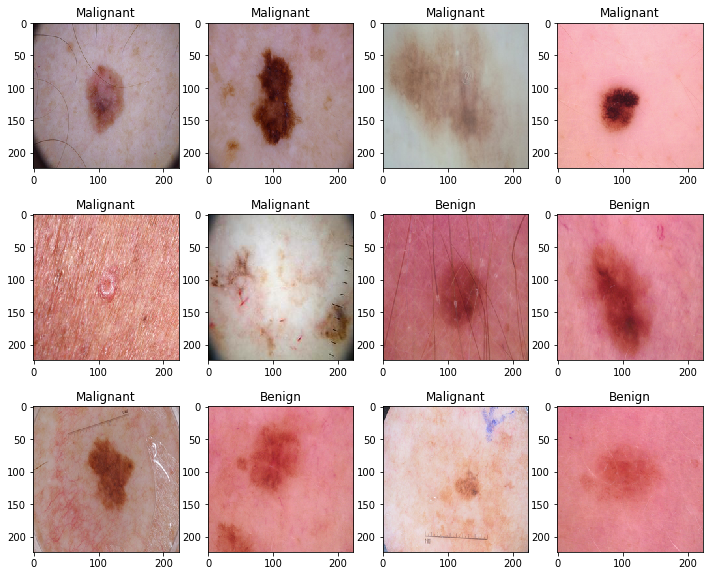

time: 1.91 s (started: 2021-05-05 17:24:17 +00:00)


In [ ]:
#Creating a figure including sub-figures:
fig=plt.figure(figsize=(12, 10))
for i in range(1, 12 +1):
    ax = fig.add_subplot(3, 4, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

## Creating catagorical labels
We will here first create a validation dataset for NN training monitoring and then covert our labels into catagorical values with one hot encoding.

https://medium.com/@michaeldelsole/what-is-one-hot-encoding-and-how-to-do-it-f0ae272f1179

In [ ]:
# One hot encoding:
#y_train = to_categorical(y_train, num_classes= 2)
#y_test = to_categorical(y_test, num_classes= 2)

time: 1.16 ms (started: 2021-05-05 17:24:19 +00:00)


# Building our own CNN

The data is ready to be processed. We will use TensorFlow to build our own architecture for the image classification task. This is still a NN and we will apply a similar workflow to create and train the model. 

The process starts with the creation of graph representation. 



In [ ]:
def build_model_CNN():
  # input array shape for the network:
  input_shape = X_train.shape[1],X_train.shape[2],X_train.shape[3]
  #Here we will use Sequential API like we did in MLP
  model = models.Sequential([
  # Now we will introduce the layers. We will start with the convolution layer:
  #https://keras.io/api/layers/convolution_layers/
  #https://keras.io/api/layers/convolution_layers/convolution2d/
  Conv2D(64,(3,3),(1,1),padding='same',activation="relu",kernel_initializer="he_uniform",input_shape=input_shape),
  #Adding the pooling layer:
  #https://keras.io/api/layers/pooling_layers/
  #https://keras.io/api/layers/pooling_layers/max_pooling2d/
  MaxPooling2D((2,2),padding='same'),
  BatchNormalization(),
  Dropout(0.2),
  #
  #Second conv. layer:
  Conv2D(64,(3,3),(1,1),padding='same',activation="relu",kernel_initializer="he_uniform"),
  MaxPooling2D((2,2),padding='same'),
  BatchNormalization(),
  Dropout(0.2),
  #
  #Third conv. layer:
  Conv2D(64,(3,3),(1,1),padding='same',activation="relu",kernel_initializer="he_uniform"),
  MaxPooling2D((2,2),padding='same'),
  BatchNormalization(),
  Dropout(0.2),
  #
  #Connecting to dense layer:
  Flatten(),
  #Ready to link MLP
  Dense(128,activation="relu",kernel_initializer="he_uniform"),
  BatchNormalization(),
  Dropout(0.3),
  Dense(1,activation="sigmoid")
  ])  
  model.compile(optimizer='Adam',loss = "binary_crossentropy", metrics=["accuracy"]) 
  return model
                             

time: 71.2 ms (started: 2021-05-05 17:24:19 +00:00)


In [ ]:
#Looking at the graph:
build_model_CNN().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 64)        2

## Model training

Our model is ready as a graph object. Now we are ready to train it with our dataset. As usual, we will create a checkpoint to save better results and use early stopping to limit the training period, as well as over fitting.

In [ ]:
#We will first create the object to feed fit() method:
myCheckpoint= keras.callbacks.ModelCheckpoint("my_best_model.h5", save_best_only=True)

time: 2.62 ms (started: 2021-05-05 17:24:19 +00:00)


In [ ]:
#For its implementation:
#https://keras.io/api/callbacks/early_stopping/
# Here patience refers to the number of epochs with no improvement after which training will be stopped.
myEarly_stopping = keras.callbacks.EarlyStopping(patience=25,restore_best_weights=True)

time: 2.22 ms (started: 2021-05-05 17:24:19 +00:00)


In [ ]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 100
batch_size = 32

time: 1.97 ms (started: 2021-05-05 17:24:19 +00:00)


In [ ]:
# Model Training:
#-----------------------------------------------------------------------------
#Building the Keras models:
model_CNN = build_model_CNN()

#Training step: Trains the model in silent mode (verbose = 0)
history= model_CNN.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.2, 
                                callbacks=[myCheckpoint,myEarly_stopping])#, verbose=0)
#Calling back the best model:
model_best= keras.models.load_model("my_best_model.h5")


Epoch 1/100
66/66 [==============================] - 21s 186ms/step - loss: 0.7611 - accuracy: 0.7572 - val_loss: 0.6642 - val_accuracy: 0.5833
Epoch 2/100
66/66 [==============================] - 10s 152ms/step - loss: 0.4517 - accuracy: 0.7962 - val_loss: 0.6110 - val_accuracy: 0.6420
Epoch 3/100
66/66 [==============================] - 10s 151ms/step - loss: 0.3829 - accuracy: 0.8175 - val_loss: 0.4830 - val_accuracy: 0.7538
Epoch 4/100
66/66 [==============================] - 10s 152ms/step - loss: 0.3740 - accuracy: 0.8198 - val_loss: 0.4304 - val_accuracy: 0.8144
Epoch 5/100
66/66 [==============================] - 10s 152ms/step - loss: 0.3374 - accuracy: 0.8339 - val_loss: 0.4204 - val_accuracy: 0.7955
Epoch 6/100
66/66 [==============================] - 10s 153ms/step - loss: 0.3193 - accuracy: 0.8496 - val_loss: 0.4411 - val_accuracy: 0.8030
Epoch 7/100
66/66 [==============================] - 10s 153ms/step - loss: 0.2910 - accuracy: 0.8727 - val_loss: 0.3861 - val_accuracy:

In [ ]:
#Lets look into the history recorded:
hist = pd.DataFrame(history.history)
hist.sample(3)

,loss,accuracy,val_loss,val_accuracy
23,0.096952,0.958748,0.445800,0.812500
7,0.279694,0.872926,0.366911,0.837121
14,0.173665,0.924135,0.339575,0.842803


time: 29.3 ms (started: 2021-05-05 17:30:37 +00:00)


In [ ]:
#Adding epoch column:
hist['epoch'] = history.epoch
# As you can see, we have the losses as well as mae for both training and CV data:
hist.sample(3)

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.606468,0.775723,0.664168,0.583333,0
28,0.060351,0.980085,0.487641,0.839015,28
7,0.279694,0.872926,0.366911,0.837121,7


time: 23.6 ms (started: 2021-05-05 17:30:37 +00:00)


In [ ]:
# Defining our function to see the evolution of error:
def plot_learning_curves(history):
  #We will omit the first 0 points for a better visualization:
  plt.plot(history['epoch'][0:],history['loss'][0:], "k--", linewidth=1.5, label="Training")
  plt.plot(history['epoch'][0:],history['val_loss'][0:], "b-.", linewidth=1.5, label="CV test")
  plt.legend()
 # plt.ylim(1,100)
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("CE Loss")

time: 8.46 ms (started: 2021-05-05 17:30:37 +00:00)


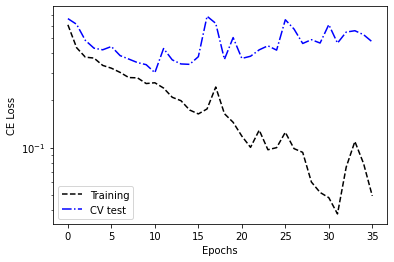

time: 565 ms (started: 2021-05-05 17:30:37 +00:00)


In [ ]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves(hist)

In [ ]:
# Defining our function to see the evolution of error:
def plot_learning_curves_2(history):
  #We will omit the first 0 points for a better visualization:
  plt.plot(history['epoch'][0:],history['accuracy'][0:], "k--", linewidth=1.5, label="Training")
  plt.plot(history['epoch'][0:],history['val_accuracy'][0:], "b-.", linewidth=1.5, label="CV test")
  plt.legend()
# plt.ylim(1,100)
# plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("Accuracy")

time: 5 ms (started: 2021-05-05 17:30:37 +00:00)


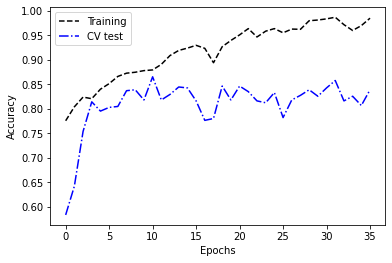

time: 286 ms (started: 2021-05-05 17:30:37 +00:00)


In [ ]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves_2(hist)

## Evaluation metrics

It is clearly seen that we are overfitting with the current model. Lets see our performance matrices. We will use confusion matrix, PR curve and ROC curve.

We will start with making predictions and then data conversion to be able to apply evaluation tools.

In [ ]:
y_test_predictions = model_best.predict(X_test)
y_test_classes = model_best.predict_classes(X_test, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


time: 2.88 s (started: 2021-05-05 17:30:38 +00:00)


In [ ]:
# seeing an example output from sigmoid layer:
print(y_test_predictions[0], y_test_classes[0])

[0.545452] [1]
time: 3.8 ms (started: 2021-05-05 17:30:41 +00:00)


`scikit-learn` metrics expect a 1D array of actual and predicted values for comparison so we must reduce the array dimensions.

In [ ]:
y_test_predictions = y_test_predictions[:, 0]
y_test_classes = y_test_classes[:, 0]

time: 1.65 ms (started: 2021-05-05 17:30:41 +00:00)


### Confusion matrix

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)
conf_matrix = confusion_matrix(y_test,y_test_classes)
conf_matrix

array([[313,  47],
       [ 57, 243]])

time: 16.6 ms (started: 2021-05-05 17:30:41 +00:00)


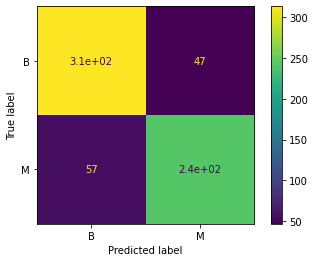

time: 272 ms (started: 2021-05-05 17:30:41 +00:00)


In [ ]:
CM = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=('B', 'M'))
CM.plot()

### Various scores

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test,y_test_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test,y_test_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test,y_test_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test,y_test_classes)
print('F1 score: %f' % f1)
kappa_score = cohen_kappa_score(y_test,y_test_classes)
print('Cohens kappa: %f' % kappa_score)
# ROC AUC
auc_score = roc_auc_score(y_test, y_test_predictions)
print('ROC AUC: %f' % auc_score)

Accuracy: 0.842424
Precision: 0.837931
Recall: 0.810000
F1 score: 0.823729
Cohens kappa: 0.681337
ROC AUC: 0.933528
time: 23.5 ms (started: 2021-05-05 17:30:41 +00:00)


### PR Curve

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.92')

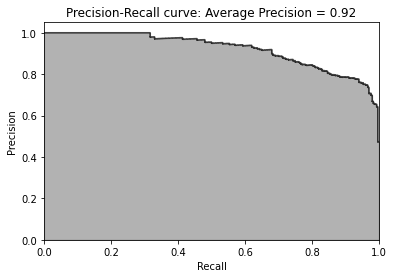

time: 257 ms (started: 2021-05-05 17:30:41 +00:00)


In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test,y_test_predictions)
average_precision = average_precision_score(y_test,y_test_predictions)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

### ROC curve


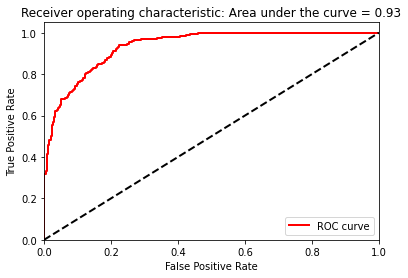

time: 205 ms (started: 2021-05-05 17:30:41 +00:00)


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test,y_test_predictions)
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

# Looking for alternatives

Our score so far is compatable to an expert already but we would like to further improve our score. We will eplore two options here together and you will be given exercises to further play with the model. The options we will explore are:

+ pooling layers & 
+ data agumentation.

## Impact of Pooling

In the basic architecture, we introduce MaxPooling to downsample the input image, with the objective of reduce the computational load, the memory usage, and the number of parameters.By doing so, it also adds a bit of regularization into the picture.

Since we are overfitting, I will increase the pooling size and a bit of further regularization.

### Model architecture

In [ ]:
def build_model_CNN_2():
  # input array shape for the network:
  input_shape = X_train.shape[1],X_train.shape[2],X_train.shape[3]
  #Here we will use Sequential API like we did in MLP
  model = models.Sequential([
  # Now we will introduce the layers. We will start with the convolution layer:
  #https://keras.io/api/layers/convolution_layers/
  #https://keras.io/api/layers/convolution_layers/convolution2d/
  Conv2D(64,(3,3),(1,1),padding='same',activation="relu",kernel_initializer="he_uniform",kernel_regularizer=regularizers.l1(0.001),input_shape=input_shape),
  #Adding the pooling layer:
  #https://keras.io/api/layers/pooling_layers/
  #https://keras.io/api/layers/pooling_layers/max_pooling2d/
  MaxPooling2D((3,3),padding='same'),
  BatchNormalization(),
  #Dropout(0.2),
  #
  #Second conv. layer:
  Conv2D(64,(3,3),(1,1),padding='same',activation="relu",kernel_initializer="he_uniform",kernel_regularizer=regularizers.l1(0.001)),
  MaxPooling2D((3,3),padding='same'),
  BatchNormalization(),
  #Dropout(0.2),
  #
  #Third conv. layer:
  Conv2D(64,(3,3),(1,1),padding='same',activation="relu",kernel_initializer="he_uniform",kernel_regularizer=regularizers.l1(0.001)),
  MaxPooling2D((3,3),padding='same'),
  BatchNormalization(),
  #Dropout(0.2),
  #
  #Connecting to dense layer:
  Flatten(),
  #Ready to link MLP
  Dense(128,activation="relu",kernel_initializer="he_uniform",kernel_regularizer=regularizers.l1(0.001)),
  BatchNormalization(),
  Dropout(0.2),
  Dense(1,activation="sigmoid")
  ])  
  model.compile(optimizer='Adam',loss = "binary_crossentropy", metrics=["accuracy"]) 
  return model
                             

time: 45.3 ms (started: 2021-05-05 17:30:41 +00:00)


In [ ]:
#Looking at the graph:
build_model_CNN_2().summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 25, 25, 64)        256       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 25, 25, 64)       

### Model training

Our model is ready as a graph object. Now we are ready to train it with our dataset. As usual, we will create a checkpoint to save better results and use early stopping to limit the training period, as well as over fitting.

In [ ]:
#We will first create the object to feed fit() method:
myCheckpoint_2= keras.callbacks.ModelCheckpoint("my_best_model_2.h5", save_best_only=True)

time: 1.09 ms (started: 2021-05-05 17:30:42 +00:00)


In [ ]:
#For its implementation:
#https://keras.io/api/callbacks/early_stopping/
# Here patience refers to the number of epochs with no improvement after which training will be stopped.
myEarly_stopping_2 = keras.callbacks.EarlyStopping(patience=25,restore_best_weights=True)

time: 2.61 ms (started: 2021-05-05 17:30:42 +00:00)


In [ ]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 100
batch_size = 32

time: 2.4 ms (started: 2021-05-05 17:30:42 +00:00)


In [ ]:
# Model Training:
#-----------------------------------------------------------------------------
#Building the Keras models:
model_CNN_2 = build_model_CNN_2()

#Training step: Trains the model in silent mode (verbose = 0)
history_2= model_CNN_2.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.2, 
                                callbacks=[myCheckpoint_2,myEarly_stopping_2])#, verbose=0)
#Calling back the best model:
model_best_2= keras.models.load_model("my_best_model_2.h5")


Epoch 1/100
66/66 [==============================] - 9s 116ms/step - loss: 13.5160 - accuracy: 0.7669 - val_loss: 7.2839 - val_accuracy: 0.5417
Epoch 2/100
66/66 [==============================] - 7s 100ms/step - loss: 5.8575 - accuracy: 0.8213 - val_loss: 4.5060 - val_accuracy: 0.5455
Epoch 3/100
66/66 [==============================] - 7s 100ms/step - loss: 3.9874 - accuracy: 0.7978 - val_loss: 3.5923 - val_accuracy: 0.5663
Epoch 4/100
66/66 [==============================] - 7s 100ms/step - loss: 3.2256 - accuracy: 0.7914 - val_loss: 3.0761 - val_accuracy: 0.5398
Epoch 5/100
66/66 [==============================] - 7s 101ms/step - loss: 2.5400 - accuracy: 0.8253 - val_loss: 2.8278 - val_accuracy: 0.5398
Epoch 6/100
66/66 [==============================] - 7s 100ms/step - loss: 2.2396 - accuracy: 0.8064 - val_loss: 2.1029 - val_accuracy: 0.6345
Epoch 7/100
66/66 [==============================] - 7s 100ms/step - loss: 1.9182 - accuracy: 0.8185 - val_loss: 1.9948 - val_accuracy: 0.753

In [ ]:
#Lets look into the history recorded:
hist_2 = pd.DataFrame(history_2.history)
hist_2.sample(3)

,loss,accuracy,val_loss,val_accuracy
70,0.449408,0.968706,0.754942,0.854167
61,0.540758,0.936463,0.805183,0.857955
33,0.775408,0.881460,0.812197,0.867424


time: 22.4 ms (started: 2021-05-05 17:38:47 +00:00)


In [ ]:
#Adding epoch column:
hist_2['epoch'] = history_2.epoch
# As you can see, we have the losses as well as mae for both training and CV data:
hist_2.sample(3)

,loss,accuracy,val_loss,val_accuracy,epoch
50,0.623495,0.908962,0.843670,0.810606,50
0,11.030511,0.786155,7.283944,0.541667,0
49,0.635129,0.911807,0.810722,0.857955,49


time: 27.3 ms (started: 2021-05-05 17:38:47 +00:00)


In [ ]:
# Defining our function to see the evolution of error:
def plot_learning_curves(history):
  #We will omit the first 0 points for a better visualization:
  plt.plot(history['epoch'][0:],history['loss'][0:], "k--", linewidth=1.5, label="Training")
  plt.plot(history['epoch'][0:],history['val_loss'][0:], "b-.", linewidth=1.5, label="CV test")
  plt.legend()
 # plt.ylim(1,100)
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("CE Loss")

time: 7.55 ms (started: 2021-05-05 17:38:47 +00:00)


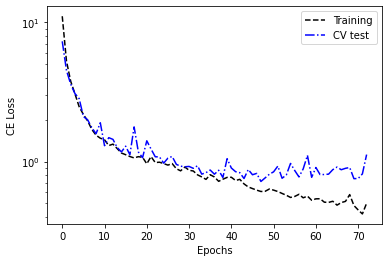

time: 745 ms (started: 2021-05-05 17:38:47 +00:00)


In [ ]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves(hist_2)

In [ ]:
# Defining our function to see the evolution of error:
def plot_learning_curves_2(history):
  #We will omit the first 0 points for a better visualization:
  plt.plot(history['epoch'][0:],history['accuracy'][0:], "k--", linewidth=1.5, label="Training")
  plt.plot(history['epoch'][0:],history['val_accuracy'][0:], "b-.", linewidth=1.5, label="CV test")
  plt.legend()
# plt.ylim(1,100)
# plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("Accuracy")

time: 6.52 ms (started: 2021-05-05 17:38:48 +00:00)


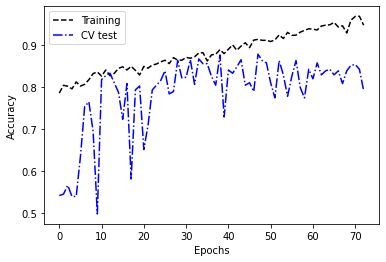

time: 240 ms (started: 2021-05-05 17:38:48 +00:00)


In [ ]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves_2(hist_2)

### Evaluation metrics

In [ ]:
y_test_predictions_2 = model_best_2.predict(X_test)
y_test_classes_2 = model_best_2.predict_classes(X_test, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


time: 1.88 s (started: 2021-05-05 17:38:48 +00:00)


In [ ]:
# seeing an example output from sigmoid layer:
print(y_test_predictions_2[0], y_test_classes_2[0])

[0.31960216] [0]
time: 1.72 ms (started: 2021-05-05 17:38:50 +00:00)


`scikit-learn` metrics expect a 1D array of actual and predicted values for comparison so we must reduce the array dimensions.

In [ ]:
y_test_predictions_2 = y_test_predictions_2[:, 0]
y_test_classes_2 = y_test_classes_2[:, 0]

time: 2.49 ms (started: 2021-05-05 17:38:50 +00:00)


#### Confusion matrix

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)
conf_matrix = confusion_matrix(y_test,y_test_classes_2)
conf_matrix

array([[310,  50],
       [ 65, 235]])

time: 14.3 ms (started: 2021-05-05 17:38:50 +00:00)


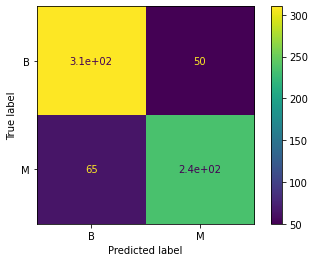

time: 241 ms (started: 2021-05-05 17:38:50 +00:00)


In [ ]:
CM = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=('B', 'M'))
CM.plot()

#### Various scores

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test,y_test_classes_2)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test,y_test_classes_2)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test,y_test_classes_2)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test,y_test_classes_2)
print('F1 score: %f' % f1)
kappa_score = cohen_kappa_score(y_test,y_test_classes_2)
print('Cohens kappa: %f' % kappa_score)
# ROC AUC
auc_score = roc_auc_score(y_test, y_test_predictions_2)
print('ROC AUC: %f' % auc_score)

Accuracy: 0.825758
Precision: 0.824561
Recall: 0.783333
F1 score: 0.803419
Cohens kappa: 0.647141
ROC AUC: 0.928009
time: 27 ms (started: 2021-05-05 17:38:50 +00:00)


#### PR Curve

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.91')

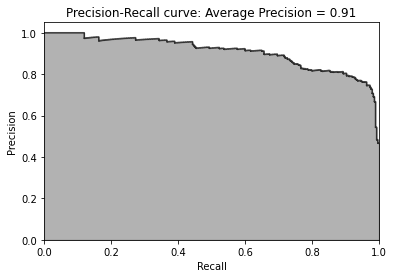

time: 217 ms (started: 2021-05-05 17:38:50 +00:00)


In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test,y_test_predictions_2)
average_precision = average_precision_score(y_test,y_test_predictions_2)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

#### ROC curve


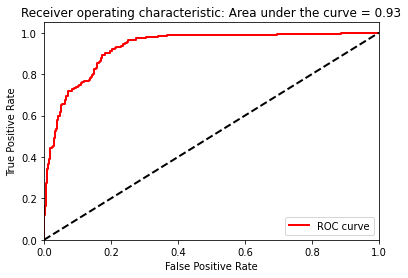

time: 199 ms (started: 2021-05-05 17:38:50 +00:00)


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test,y_test_predictions_2)
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

# Increasing the volume of the data in image processing

It looks like we have hit the wall. We may push the predictive accuracy to a bit higher levels with fine tuning the model but there may be an alternative option as well. 

Image data augmentation is a useful method that can be used to artificially expand the size of a training dataset by creating slighlty modified versions of the original images in the dataset. Good news is we do not have to code it from the scratch; TF (Keras) already has a solution: `ImageDataGenerator` class:

https://keras.io/api/preprocessing/image/

```
tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode="nearest",
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    dtype=None,
)

```

The options include, but not limited to

* `width_shift_range` and `height_shift_range`:  shifts the image,
* `horizontal_flip` and `vertical_flip` :  flips images
* `rotation_range` : rotates image
* `brightness_range` : setting brightness 
* `zoom_range` : image zooming

see also:

https://www.tensorflow.org/tutorials/images/data_augmentation

https://towardsdatascience.com/exploring-image-data-augmentation-with-keras-and-tensorflow-a8162d89b844

https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/





## Implementation

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False,  
        zca_whitening=False, 
        rotation_range=20, 
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2,
        horizontal_flip=True,  
        vertical_flip=True, 
        preprocessing_function=None,
        validation_split=0.2)

datagen.fit(X_train)

time: 2.06 s (started: 2021-05-05 18:36:58 +00:00)


In [ ]:
#We will first create the object to feed fit() method:
myCheckpoint_3= keras.callbacks.ModelCheckpoint("my_best_model_3.h5", save_best_only=True)

time: 1.41 ms (started: 2021-05-05 18:37:05 +00:00)


In [ ]:
#For its implementation:
#https://keras.io/api/callbacks/early_stopping/
# Here patience refers to the number of epochs with no improvement after which training will be stopped.
#myEarly_stopping_3 = keras.callbacks.EarlyStopping(patience=25,restore_best_weights=True)

time: 1.72 ms (started: 2021-05-05 18:37:06 +00:00)


In [ ]:
# Alternative checkpoint - if accuracy doesn't improve after 3 epoch then reduce lr by factor 0.5 
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.618,patience=3, min_lr=0.00001)

time: 4.72 ms (started: 2021-05-05 18:37:06 +00:00)


In [ ]:
# Training the model:
# here we will fit the model on batches with real-time data augmentation;
history_3 = model_CNN.fit(datagen.flow(X_train, y_train, batch_size=batch_size,subset='training'),
                          epochs=num_epochs, 
                          #validation_split=0.2,
                          validation_data=datagen.flow(X_train, y_train, batch_size=batch_size, subset='validation'), 
                          callbacks=[myCheckpoint_3,reduce_lr])#, verbose=0))

#Calling back the best model:
model_best_3= keras.models.load_model("my_best_model_3.h5")

Epoch 1/100
66/66 [==============================] - 34s 509ms/step - loss: 0.1997 - accuracy: 0.9133 - val_loss: 0.2886 - val_accuracy: 0.8653
Epoch 2/100
66/66 [==============================] - 33s 499ms/step - loss: 0.1963 - accuracy: 0.9199 - val_loss: 0.2985 - val_accuracy: 0.8824
Epoch 3/100
66/66 [==============================] - 33s 496ms/step - loss: 0.1989 - accuracy: 0.9147 - val_loss: 0.2946 - val_accuracy: 0.8729
Epoch 4/100
66/66 [==============================] - 33s 493ms/step - loss: 0.2002 - accuracy: 0.9095 - val_loss: 0.3079 - val_accuracy: 0.8577
Epoch 5/100
66/66 [==============================] - 33s 495ms/step - loss: 0.1994 - accuracy: 0.9161 - val_loss: 0.3189 - val_accuracy: 0.8691
Epoch 6/100
66/66 [==============================] - 33s 496ms/step - loss: 0.1865 - accuracy: 0.9190 - val_loss: 0.2987 - val_accuracy: 0.8615
Epoch 7/100
66/66 [==============================] - 33s 496ms/step - loss: 0.2017 - accuracy: 0.9152 - val_loss: 0.3029 - val_accuracy:

In [ ]:
#Lets look into the history recorded:
hist_3 = pd.DataFrame(history_3.history)
hist_3.head(3)

,loss,accuracy,val_loss,val_accuracy,lr
0,0.199696,0.913270,0.288564,0.865275,0.000034
1,0.196285,0.919905,0.298460,0.882353,0.000034
2,0.198887,0.914692,0.294615,0.872865,0.000034


time: 32 ms (started: 2021-05-05 19:33:33 +00:00)


In [ ]:
#Lets look into the history recorded:
hist_3 = pd.DataFrame(history_3.history)
hist_3.sample(3)

,loss,accuracy,val_loss,val_accuracy,lr
9,0.197116,0.916588,0.316636,0.861480,0.000013
57,0.196346,0.914218,0.322060,0.865275,0.000010
85,0.185266,0.919431,0.325926,0.867173,0.000010


time: 19.9 ms (started: 2021-05-05 19:33:33 +00:00)


In [ ]:
#Adding epoch column:
hist_3['epoch'] = history_3.epoch
# As you can see, we have the losses as well as mae for both training and CV data:
hist_3.sample(3)

,loss,accuracy,val_loss,val_accuracy,lr,epoch
66,0.184534,0.924171,0.329185,0.857685,0.00001,66
16,0.192925,0.915640,0.305827,0.851992,0.00001,16
43,0.198941,0.909953,0.325047,0.867173,0.00001,43


time: 26.8 ms (started: 2021-05-05 19:33:33 +00:00)


In [ ]:
# Defining our function to see the evolution of error:
def plot_learning_curves(history):
  #We will omit the first 0 points for a better visualization:
  plt.plot(history['epoch'][0:],history['loss'][0:], "k--", linewidth=1.5, label="Training")
  plt.plot(history['epoch'][0:],history['val_loss'][0:], "b-.", linewidth=1.5, label="CV test")
  plt.legend()
 # plt.ylim(1,100)
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("CE Loss")

time: 3.8 ms (started: 2021-05-05 19:33:33 +00:00)


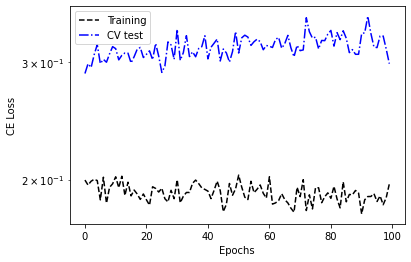

time: 432 ms (started: 2021-05-05 19:33:33 +00:00)


In [ ]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves(hist_3)

In [ ]:
# Defining our function to see the evolution of error:
def plot_learning_curves_2(history):
  #We will omit the first 0 points for a better visualization:
  plt.plot(history['epoch'][0:],history['accuracy'][0:], "k--", linewidth=1.5, label="Training")
  plt.plot(history['epoch'][0:],history['val_accuracy'][0:], "b-.", linewidth=1.5, label="CV test")
  plt.legend()
  plt.ylim(0.5,1)
# plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("Accuracy")

time: 8.33 ms (started: 2021-05-05 19:37:44 +00:00)


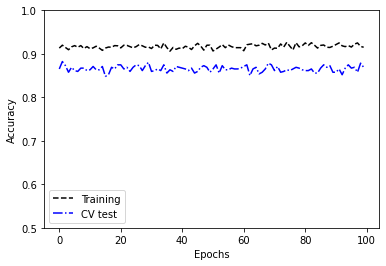

time: 240 ms (started: 2021-05-05 19:37:47 +00:00)


In [ ]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves_2(hist_3)

### Evaluation metrics

In [ ]:
y_test_predictions_3 = model_best_3.predict(X_test)
y_test_classes_3 = model_best_3.predict_classes(X_test, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


time: 2.34 s (started: 2021-05-05 19:33:34 +00:00)


In [ ]:
# seeing an example output from sigmoid layer:
print(y_test_predictions_3[0], y_test_classes_3[0])

[0.6846205] [1]
time: 3.06 ms (started: 2021-05-05 19:33:36 +00:00)


`scikit-learn` metrics expect a 1D array of actual and predicted values for comparison so we must reduce the array dimensions.

In [ ]:
y_test_predictions_3 = y_test_predictions_3[:, 0]
y_test_classes_3 = y_test_classes_3[:, 0]

time: 2.22 ms (started: 2021-05-05 19:33:36 +00:00)


#### Confusion matrix

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)
conf_matrix = confusion_matrix(y_test,y_test_classes_3)
conf_matrix

array([[332,  28],
       [ 55, 245]])

time: 11.8 ms (started: 2021-05-05 19:33:36 +00:00)


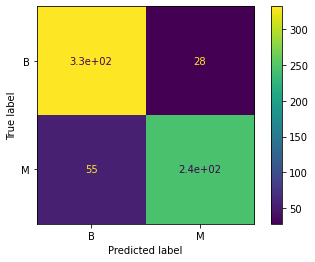

time: 306 ms (started: 2021-05-05 19:33:36 +00:00)


In [ ]:
CM = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=('B', 'M'))
CM.plot()

#### Various scores

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test,y_test_classes_3)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test,y_test_classes_3)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test,y_test_classes_3)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test,y_test_classes_3)
print('F1 score: %f' % f1)
kappa_score = cohen_kappa_score(y_test,y_test_classes_3)
print('Cohens kappa: %f' % kappa_score)
# ROC AUC
auc_score = roc_auc_score(y_test, y_test_predictions_3)
print('ROC AUC: %f' % auc_score)

Accuracy: 0.874242
Precision: 0.897436
Recall: 0.816667
F1 score: 0.855148
Cohens kappa: 0.744472
ROC AUC: 0.949306
time: 25.1 ms (started: 2021-05-05 19:33:36 +00:00)


#### PR Curve

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.94')

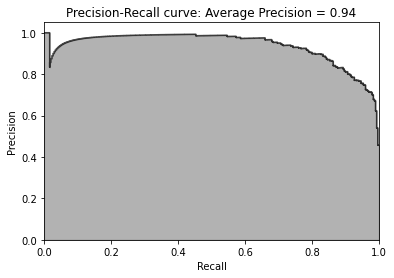

time: 246 ms (started: 2021-05-05 19:33:36 +00:00)


In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test,y_test_predictions_3)
average_precision = average_precision_score(y_test,y_test_predictions_3)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

#### ROC curve


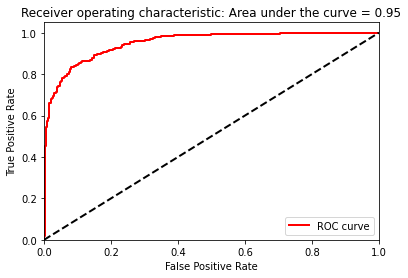

time: 238 ms (started: 2021-05-05 19:33:37 +00:00)


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test,y_test_predictions_3)
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

# Exercise options

+ Play with learning rate and regularization options.

+ play with the architecture.

+ try different number of filters.

+ explore the impact of pooling and maxpooling. 

# Reading materials and further references


## Basic tutorials and resources on CNN

+ [Basic CNN implementation](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/)




## Previous challenges and calls for the task:

+ [ISIC 2018: Skin Lesion Analysis Towards Melanoma Detection](https://challenge2018.isic-archive.com/)

+  [HAM10000 dataset](https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000)

+ [SIIM-ISIC Melanoma Classification](https://www.kaggle.com/c/siim-isic-melanoma-classification/data)







## Case study: Skin cancer classification

+ [What is melanoma?](https://www.youtube.com/watch?v=mkYBxfKDyv0)

+ [Skin cancer classification with deep learning](https://cs.stanford.edu/people/esteva/nature/)

+ [Skin Cancer Classification Using Convolutional Neural Networks: Systematic Review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6231861/)

+ [DePicT Melanoma Deep-CLASS](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-020-3351-y)
